# Simple automation

This notebook can be used for rudimentary automation of the STED in a single field-of-view

the general sequence is:
* 1) prepare a measurement in Imspector consisting of 2 configurations
    * an overview (one channel)
    * detailed measurement
* 2) set filepath and running index
* 3) take an overview image manually
* 4) this script will detect cells in image (simple thresholding) an do the detailed measurement of each cell
* 5) repeat from 3) if necessar

## Imports, run this once

In [96]:
from specpy import *
import numpy as np
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
from Util.tile_util import middle2corner
%matplotlib inline

## Change filepath, running index or threshold

In [262]:
fileprefix = '\\Users\\RESOLFT\\Desktop\\Test\\20160616_k562_sirdna_vs_nospacer_water_0'
runidx = 0

In [249]:
t = 30

## 1) get overview and detect cells, display segmentation

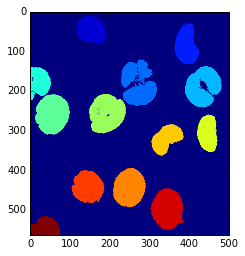

In [274]:
im = Imspector()
ms = im.active_measurement()

c = ms.configuration(ms.configuration_names()[0])
ms.activate(c)
#ms.active_configuration().name()

objs = get_objects(ms, threshold = t)
plot_objs(ms, threshold = t)
offset = get_offset(ms)
ps = get_pixsize(ms)

pixx, pixy = get_pdims(ms)

## 2) do measurement for all cells detected in 1)

In [275]:
for o in objs:
    
    # ignore on corner
    if ((o[0].start == 0) or (o[1].start == 0) or (o[0].stop == pixy) or ((o[1].stop == pixx))):
        continue
    
    c = ms.configuration(ms.configuration_names()[0])
    ms.activate(c)
    
    ce, r = obj_to_off(o, pixsize=ps, offset=middle2corner(get_offset(ms), get_lens(ms)))

    c = ms.configuration(ms.configuration_names()[1])
    ms.activate(c)
    set_field(ms, ce, r)
    im.run(ms)
    
    ms.save_as(fileprefix + str(runidx) + '.msr')
    runidx += 1

## Definitions

In [239]:
def get_pixsize(ms):
    return ms.parameter('ExpControl/scan/range/x/psz')
def get_offset(ms):
    return (ms.parameter('ExpControl/scan/range/x/off'),  ms.parameter('ExpControl/scan/range/y/off'))
def get_lens(ms):
    return (ms.parameter('ExpControl/scan/range/x/len'),  ms.parameter('ExpControl/scan/range/y/len'))
def get_pdims(ms):
    return (ms.parameter('ExpControl/scan/range/x/res'),  ms.parameter('ExpControl/scan/range/y/res'))



def set_field(ms, offs, siz):
    offx = offs[0]
    offy = offs[1]
    sizx = siz[0]
    sizy = siz [1]
    ms.set_parameter('ExpControl/scan/range/x/off', offx)
    ms.set_parameter('ExpControl/scan/range/y/off', offy)
    ms.set_parameter('ExpControl/scan/range/x/len', sizx)
    ms.set_parameter('ExpControl/scan/range/y/len', sizy)    
    
def get_objects(ms, threshold = 10):
    st = ms.stack(0)
    st.data()[0,0,:,:]
    segmented = st.data()[0,0,:,:] >= threshold
    #plt.imshow(st.data()[0,0,:,:] >= 2)
    objs, labels = ndi.label(segmented)
    masked = np.bincount(objs.ravel()) > 500
    masked[0] = 0
    clean = masked[objs]
    objs2 = ndi.find_objects(ndi.label(clean)[0])
    return objs2

def plot_objs(ms, threshold = 10):
    st = ms.stack(0)
    st.data()[0,0,:,:]
    segmented = st.data()[0,0,:,:] >= threshold
    #plt.imshow(st.data()[0,0,:,:] >= 2)
    objs, labels = ndi.label(segmented)
    masked = np.bincount(objs.ravel()) > 500
    masked[0] = 0
    clean = masked[objs]
    plt.imshow(ndi.label(clean)[0])
    
def obj_to_off(obj, pixsize = 2e-8, offset = (0, 0), factor = 1.2):
    sly = obj[0]
    slx = obj[1]
    sizx = (slx.stop - slx.start) * pixsize * factor
    sizy = (sly.stop - sly.start) * pixsize * factor
    cx = (slx.start + 0.5 * (slx.stop - slx.start)) * pixsize + offset[0]
    cy = (sly.start + 0.5 * (sly.stop - sly.start)) * pixsize + offset[1]
    return((cx, cy),(sizx, sizy))

## Tests / Misc.

In [173]:
ce, r = obj_to_off(objs[obj_idx], pixsize=ps, offset=offset)
ce

middle2corner(get_offset(ms), get_lens(ms))
ms.save_as('\\Users\\RESOLFT\\Desktop\\testAAA.msr')